In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import  keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime



In [120]:
#Load Data
df = pd.read_csv('data/forecasted_master_data.csv')

df['Year'] = pd.to_datetime(df['Year']).dt.year


#Drop country from data frame
df.drop(columns='Country', axis=1,inplace=True)
#Create a test data from forcasted data frame
test_data = df[df['temp_change'].isna()]

#Create train data
train_data = df[df['temp_change'].notna()]

#Disaply both test and train data shape

display(test_data.shape, train_data.shape)




(1770, 6)

(9680, 6)

In [121]:
#Prapare training data for deep learning modeling 
#Create scaler and scle X_train and test data
scaler = StandardScaler()
scaler.fit(train_data)
train_scaled = pd.DataFrame(scaler.transform(train_data), columns=train_data.columns)

#Scaled test data
test_data_scaled = pd.DataFrame(scaler.transform(test_data), columns=train_data.columns)

X_train = train_scaled.drop(columns='temp_change', axis= 1)
y_train = train_scaled['temp_change']



In [122]:
#Create deep learning model
model = Sequential()
model.add(Dense(128, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [123]:
# Train the model

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])



Epoch 1/1000
242/242 [==============================] - 1s 3ms/step - loss: 0.9600 - mae: 0.7959 - val_loss: 1.0014 - val_mae: 0.7972
Epoch 2/1000
242/242 [==============================] - 1s 2ms/step - loss: 0.9149 - mae: 0.7681 - val_loss: 0.9080 - val_mae: 0.7701
Epoch 3/1000
242/242 [==============================] - 1s 3ms/step - loss: 0.8805 - mae: 0.7421 - val_loss: 0.9253 - val_mae: 0.7787
Epoch 4/1000
242/242 [==============================] - 1s 3ms/step - loss: 0.8591 - mae: 0.7263 - val_loss: 0.9087 - val_mae: 0.7710
Epoch 5/1000
242/242 [==============================] - 1s 3ms/step - loss: 0.8485 - mae: 0.7161 - val_loss: 0.8858 - val_mae: 0.7627
Epoch 6/1000
242/242 [==============================] - 1s 3ms/step - loss: 0.8459 - mae: 0.7144 - val_loss: 0.9054 - val_mae: 0.7460
Epoch 7/1000
242/242 [==============================] - 1s 3ms/step - loss: 0.8399 - mae: 0.7090 - val_loss: 0.9090 - val_mae: 0.7646
Epoch 8/1000
242/242 [==============================] - 1s 3ms

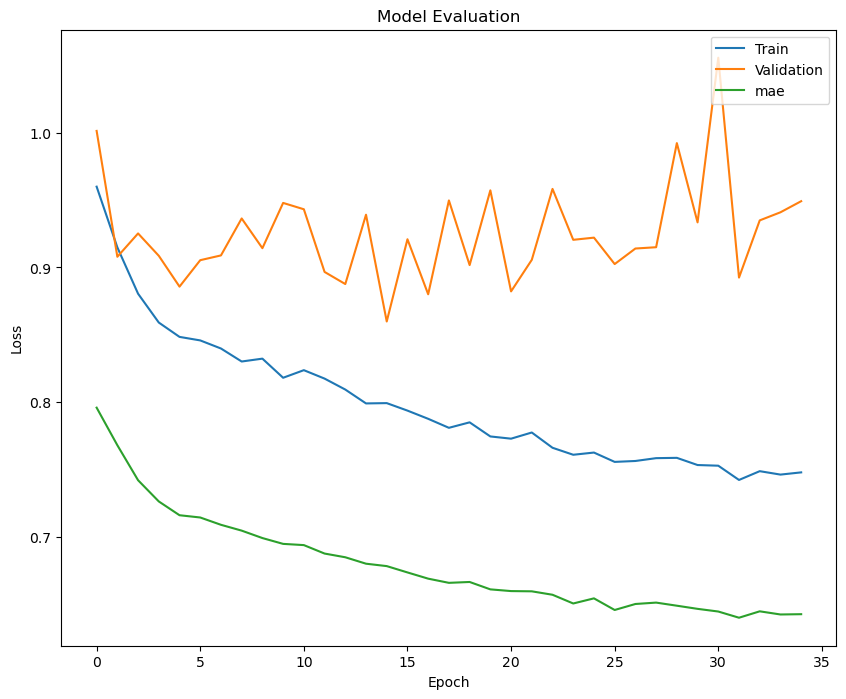

In [146]:
#Plot Model Evaluation values
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['mae'])
plt.title('Model Evaluation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','mae'], loc='upper right')
plt.show()

In [125]:
model.save('Models/emission.h5')

In [133]:
#Predict test data
data_to_predict = test_data_scaled.drop(columns='temp_change', axis=1)

pred_temp_change =  model.predict(data_to_predict)

56/56 [==============================] - 0s 2ms/step


In [135]:
#Combine predicted value to test data
test_data_predicted = df[df['temp_change'].isna()].drop(columns='temp_change', axis = 1)

test_data_predicted['Pred_temp_change'] = pred_temp_change

## Plot Predicted temprature cahnge over years

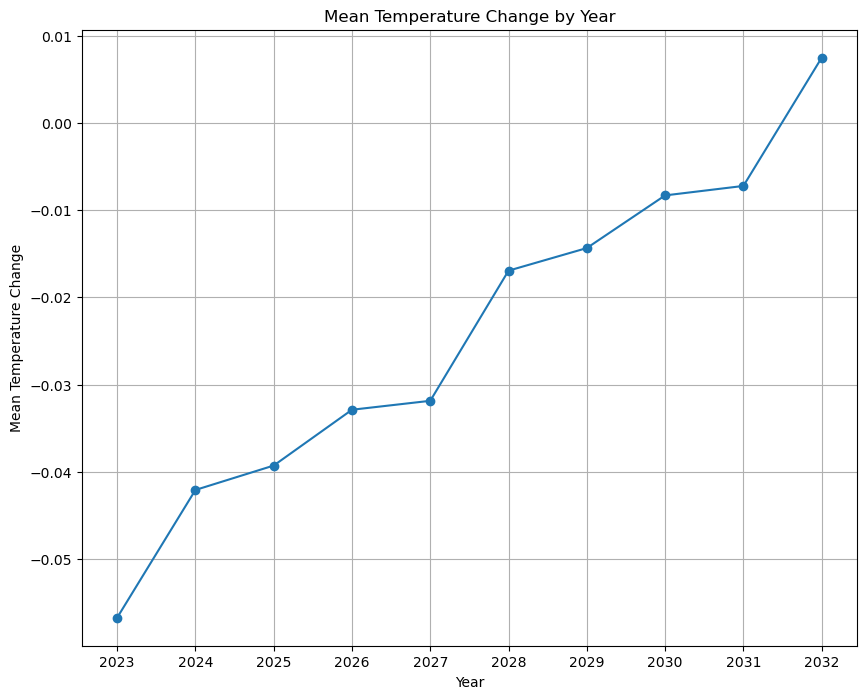

In [147]:

mean_temp_change =test_data_predicted.groupby('Year')['Pred_temp_change'].mean()

# Plotting the data
plt.figure(figsize=(10, 8))
plt.plot(mean_temp_change.index, mean_temp_change.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Mean Temperature Change')
plt.title('Mean Temperature Change by Year')
plt.grid(True)
plt.xticks(mean_temp_change.index)
plt.show()